In [152]:
import cv2
cluster = 4
def preprocess_image(image_path):
    # Baca gambar
    img = cv2.imread(image_path)
    # Resize gambar menjadi 100x100
    resized_img = cv2.resize(img, (100, 100))
    return resized_img


In [153]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def extract_and_show_histogram(hsv_img):
    # Visualisasi histogram untuk setiap kanal
    plt.figure(figsize=(12, 4))
    
    # Plot histogram untuk Hue
    plt.subplot(1, 3, 1)
    plt.title('Hue Channel')
    plt.hist(hsv_img[:, :, 0].ravel(), bins=180, range=[0, 180], color='r')
    plt.xlabel('Hue')
    plt.ylabel('Frequency')
    
    # Plot histogram untuk Saturation
    plt.subplot(1, 3, 2)
    plt.title('Saturation Channel')
    plt.hist(hsv_img[:, :, 1].ravel(), bins=256, range=[0, 256], color='g')
    plt.xlabel('Saturation')
    plt.ylabel('Frequency')

    # Plot histogram untuk Value
    plt.subplot(1, 3, 3)
    plt.title('Value Channel')
    plt.hist(hsv_img[:, :, 2].ravel(), bins=256, range=[0, 256], color='b')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Tampilkan histogram
    plt.tight_layout()
    plt.show()

def extract_features(image):
    # Konversi gambar ke HSV
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Ekstrak histogram warna
    hist = cv2.calcHist([hsv_img], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    # Normalisasi histogram
    cv2.normalize(hist, hist)
    # Visualisasi histogram dengan gambar yang sudah diubah ke HSV
    extract_and_show_histogram(hsv_img)
    return hist.flatten()


In [154]:
import numpy as np

def euclidean_distance(point1, point2):
    """Hitung jarak Euclidean antara dua titik."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def kmeans_manual(features, k, max_iters=100):
    """Fungsi KMeans manual."""
    step = len(features) // k
    centroids = np.array([features[i * step] for i in range(k)])

    for _ in range(max_iters):
        # 2. Assign cluster
        labels = np.zeros(features.shape[0])
        for i in range(features.shape[0]):
            distances = np.array([euclidean_distance(features[i], centroid) for centroid in centroids])
            labels[i] = np.argmin(distances)  # Tetapkan ke cluster terdekat

        # 3. Update centroid
        new_centroids = np.zeros(centroids.shape)
        for j in range(k):
            if np.any(labels == j):  # Pastikan ada data di cluster
                new_centroids[j] = features[labels == j].mean(axis=0)

        # 4. Periksa konvergensi (jika centroid tidak berubah)
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids
    return labels, centroids

In [155]:
import numpy as np

def euclidean_distance(point1, point2):
    """Hitung jarak Euclidean antara dua titik."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def calculate_distance_matrix(features):
    """Buat matriks jarak antara setiap titik fitur."""
    num_points = features.shape[0]
    distance_matrix = np.zeros((num_points, num_points))
    
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distance_matrix[i, j] = euclidean_distance(features[i], features[j])
            distance_matrix[j, i] = distance_matrix[i, j]
    
    return distance_matrix

def find_closest_clusters(distance_matrix, active_clusters):
    """Cari dua cluster terdekat berdasarkan matriks jarak."""
    min_distance = np.inf
    cluster_pair = (-1, -1)
    
    for i in active_clusters:
        for j in active_clusters:
            if i < j and distance_matrix[i, j] < min_distance:
                min_distance = distance_matrix[i, j]
                cluster_pair = (i, j)
    
    return cluster_pair, min_distance

def update_distance_matrix(distance_matrix, cluster_a, cluster_b):
    """Perbarui matriks jarak setelah dua cluster digabung."""
    # Complete-linkage: gunakan jarak maksimum antara anggota cluster yang digabung
    for i in range(distance_matrix.shape[0]):
        if i != cluster_a and i != cluster_b:
            distance_matrix[cluster_a, i] = max(distance_matrix[cluster_a, i], distance_matrix[cluster_b, i])
            distance_matrix[i, cluster_a] = distance_matrix[cluster_a, i]
    
    # Hapus jarak untuk cluster_b (gabung ke cluster_a)
    distance_matrix = np.delete(distance_matrix, cluster_b, axis=0)
    distance_matrix = np.delete(distance_matrix, cluster_b, axis=1)
    
    return distance_matrix

def hierarchical_clustering(features, num_clusters):
    """Algoritma Agglomerative Hierarchical Clustering."""
    num_points = features.shape[0]
    
    # Awal: Setiap titik adalah cluster
    clusters = {i: [i] for i in range(num_points)}
    active_clusters = list(clusters.keys())
    
    # Buat matriks jarak awal
    distance_matrix = calculate_distance_matrix(features)
    
    while len(active_clusters) > num_clusters:
        # Temukan dua cluster terdekat
        (cluster_a, cluster_b), min_distance = find_closest_clusters(distance_matrix, active_clusters)
        
        if cluster_a in clusters and cluster_b in clusters:
            # Gabungkan cluster_b ke cluster_a
            clusters[cluster_a].extend(clusters[cluster_b])
            del clusters[cluster_b]  # Hapus cluster_b dari clusters
            active_clusters.remove(cluster_b)  # Hapus cluster_b dari daftar aktif
        
            # Perbarui matriks jarak
            distance_matrix = update_distance_matrix(distance_matrix, cluster_a, cluster_b)
            print(clusters)
    
    return clusters

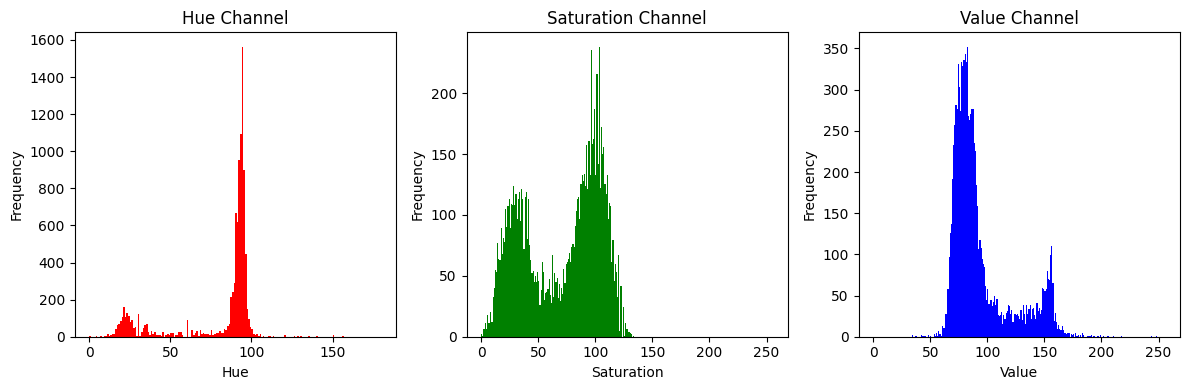

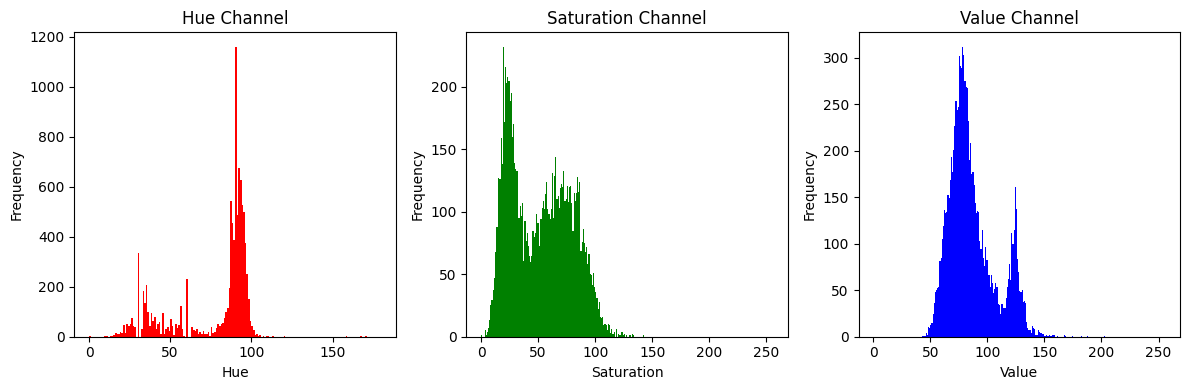

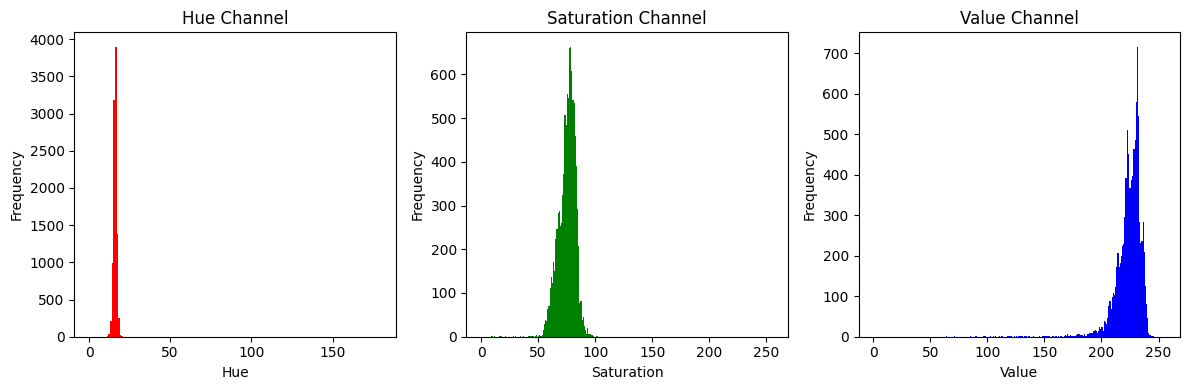

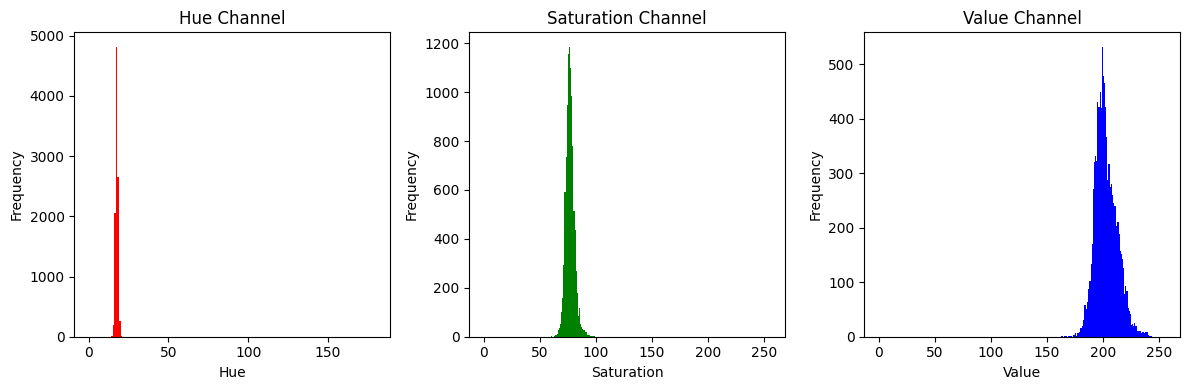

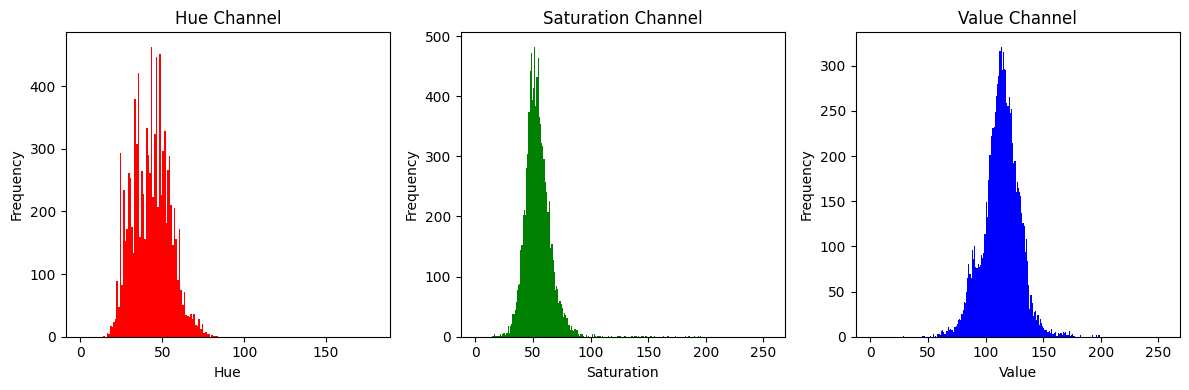

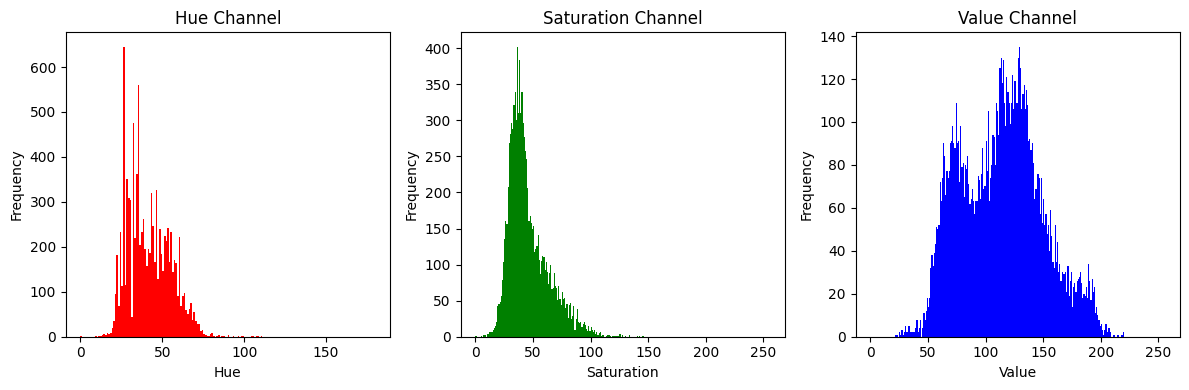

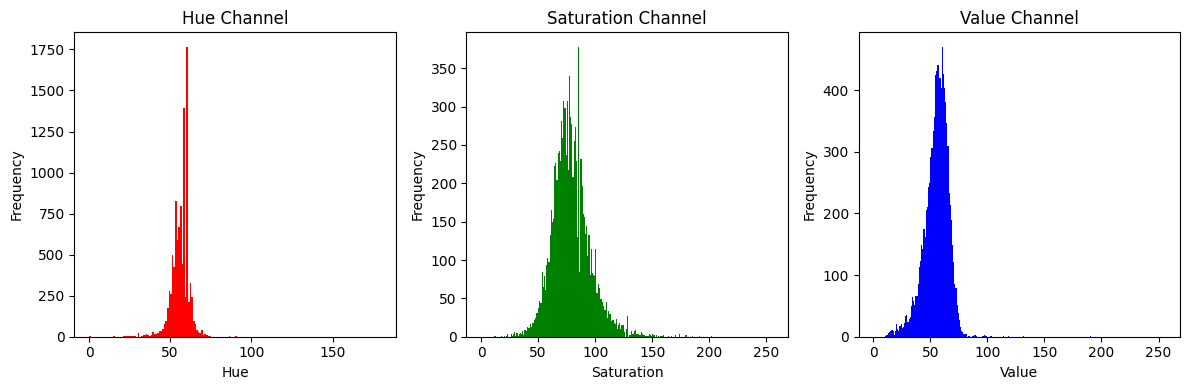

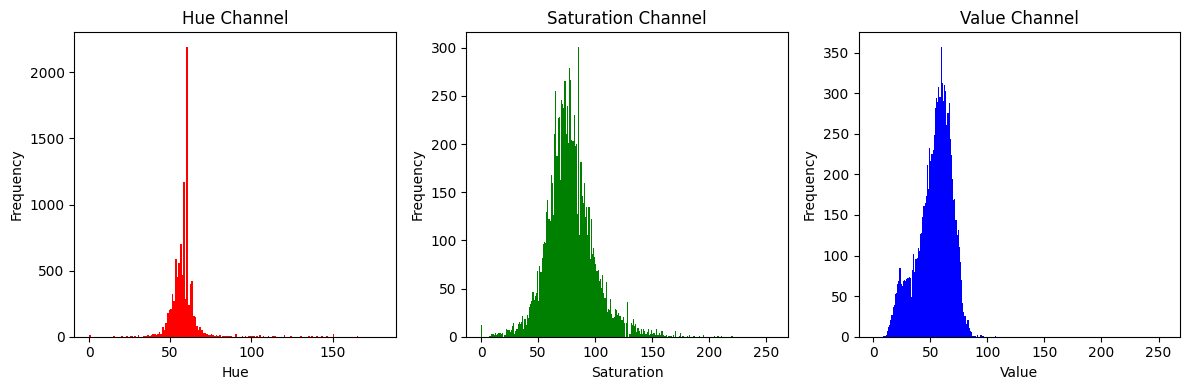

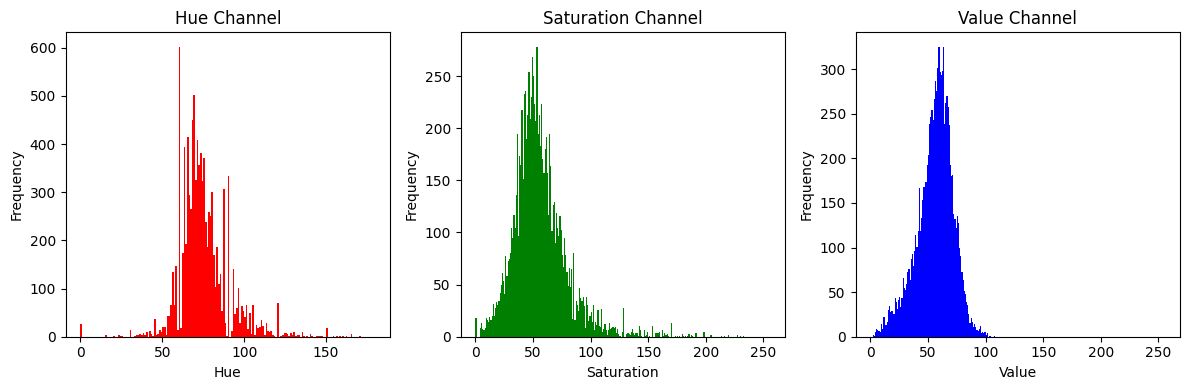

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6, 7], 8: [8]}


IndexError: index 8 is out of bounds for axis 1 with size 8

In [156]:
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Anggap kita sudah punya data fitur dari setiap gambar
features = []
data_folder = 'data/'
labelimg = []
# Dapatkan semua file di dalam folder data
for file_name in os.listdir(data_folder):
    # Periksa apakah file adalah gambar (extensi jpg, png, dll.)
    if file_name.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(data_folder, file_name)
        labelimg.append(file_name)
        img = preprocess_image(img_path)
        feature = extract_features(img)
        features.append(feature)

features = np.array(features)

# Tentukan jumlah cluster k (misalnya 3)
# labels, kmeans = kmeans_manual(features, k=cluster, max_iters=10000)
labelh = hierarchical_clustering(features, cluster)
# model = AgglomerativeClustering(n_clusters=cluster, linkage='ward')
# labelh = model.fit_predict(features)

# Print hasil clustering
print("Cluster labelh:", labelh)

# np.savetxt('a.txt', features, delimiter=',')
print(labelh)  # Output label cluster dari setiap gambar


In [125]:
import matplotlib.pyplot as plt

for i in range(cluster):  # Misal ada 3 cluster
    cluster_images = [labelimg[j] for j in range(len(labelimg)) if labels[j] == i]
    print(f"Cluster {i}: {cluster_images}")
for i in range(l):  # Misal ada 3 cluster
    cluster_images = [labelimg[j] for j in range(len(labelimg)) if labels[j] == i]
    print(f"Cluster {i}: {cluster_images}")


Cluster 0: ['beach_364.jpg', 'beach_365.jpg']
Cluster 1: ['desert_72.jpg', 'desert_77.jpg']
Cluster 2: ['farmland_64.jpg', 'farmland_7.jpg']
Cluster 3: ['forest_248.jpg', 'forest_249.jpg', 'forest_8.jpg']


In [126]:
print(labelh)

[2 2 1 1 3 3 0 0 0]
